<a href="https://colab.research.google.com/github/sanjaydinesh19/lstm-footwear-analysis/blob/main/LSTM_Pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ============================
# 1.1 Runtime & library check
# ============================
import torch, sys
print("Python:", sys.version)
print("PyTorch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())



Python: 3.12.11 (main, Jun  4 2025, 08:56:18) [GCC 11.4.0]
PyTorch: 2.8.0+cu126
CUDA available: True


In [2]:
# ============================
# 1.2 Upload the dataset
# ============================
DATA_PATH = "/content/drive/MyDrive/Research/Time Series Footwear/data.csv"

In [3]:
# ============================
# 1.3 Read CSV & inspect
# ============================
import pandas as pd
import numpy as np

df = pd.read_csv(DATA_PATH)

# Parse week_end_date as datetime
if 'week_end_date' in df.columns:
    df['week_end_date'] = pd.to_datetime(df['week_end_date'], errors='coerce')

print("Shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nDTypes:\n", df.dtypes)
print("\nDate range:", df['week_end_date'].min(), "→", df['week_end_date'].max())

display(df.head(10))

# Missing values report
na_counts = df.isna().sum().sort_values(ascending=False)
display(na_counts.to_frame("missing_count").T)


Shape: (8000, 13)

Columns: ['week_end_date', 'store_id', 'product_id', 'units_sold', 'units_returned', 'unit_price_inr', 'revenue_inr', 'promo_flag', 'discount_rate', 'avg_temp_c', 'rainfall_mm', 'neighborhood_trend_index', 'is_festival_season']

DTypes:
 week_end_date               datetime64[ns]
store_id                            object
product_id                          object
units_sold                           int64
units_returned                       int64
unit_price_inr                       int64
revenue_inr                          int64
promo_flag                           int64
discount_rate                      float64
avg_temp_c                         float64
rainfall_mm                        float64
neighborhood_trend_index           float64
is_festival_season                   int64
dtype: object

Date range: 2024-01-07 00:00:00 → 2025-07-13 00:00:00


,week_end_date,store_id,product_id,units_sold,units_returned,unit_price_inr,revenue_inr,promo_flag,discount_rate,avg_temp_c,rainfall_mm,neighborhood_trend_index,is_festival_season
0,2024-01-07,ST01,P001,24,2,2038,48912,0,0.15,28.8,31.5,95.3,1
1,2024-01-07,ST01,P002,20,2,1547,30940,0,0.00,26.7,12.0,98.8,1
2,2024-01-07,ST01,P003,15,4,2328,34920,0,0.00,24.4,34.2,102.9,1
3,2024-01-07,ST01,P004,21,0,3053,64113,0,0.00,24.3,13.3,115.2,1
4,2024-01-07,ST01,P005,12,2,961,11532,0,0.20,23.8,37.8,107.9,1
5,2024-01-07,ST01,P006,25,2,1563,39075,0,0.00,30.9,7.3,94.9,1
6,2024-01-07,ST01,P007,16,2,2498,39968,0,0.00,26.0,29.0,91.0,1
7,2024-01-07,ST01,P008,17,2,2695,45815,0,0.00,25.4,24.9,99.2,1
8,2024-01-07,ST01,P009,20,3,2681,53620,0,0.00,25.8,15.5,100.9,1
9,2024-01-07,ST01,P010,24,5,2522,60528,0,0.15,21.6,0.0,108.9,1


,week_end_date,store_id,product_id,units_sold,units_returned,unit_price_inr,revenue_inr,promo_flag,discount_rate,avg_temp_c,rainfall_mm,neighborhood_trend_index,is_festival_season
missing_count,0,0,0,0,0,0,0,0,0,0,0,0,0


In [4]:
# ============================
# 1.4 Basic stats & product coverage
# ============================
n_products = df['product_id'].nunique()
n_weeks = df['week_end_date'].nunique()
print(f"Products: {n_products} | Weeks: {n_weeks}")

# How many weeks per product
prod_counts = df.groupby('product_id')['week_end_date'].count().sort_values(ascending=False)
display(prod_counts.head(10).to_frame("rows_per_product").T)

# Descriptive stats for key metrics
display(df[["units_sold","unit_price_inr","discount_rate","revenue_inr"]].describe().T)



Products: 20 | Weeks: 80


product_id,P001,P002,P003,P004,P005,P006,P007,P008,P009,P010
rows_per_product,400,400,400,400,400,400,400,400,400,400


,count,mean,std,min,25%,50%,75%,max
units_sold,8000.0,19.493375,4.797977,4.0,16.00,19.0,23.00,39.0
unit_price_inr,8000.0,2399.925250,922.606675,800.0,1623.75,2373.0,3193.25,3998.0
discount_rate,8000.0,0.044844,0.072185,0.0,0.00,0.0,0.10,0.2
revenue_inr,8000.0,46731.319375,21609.202955,5964.0,29478.75,44140.5,61248.00,153777.0


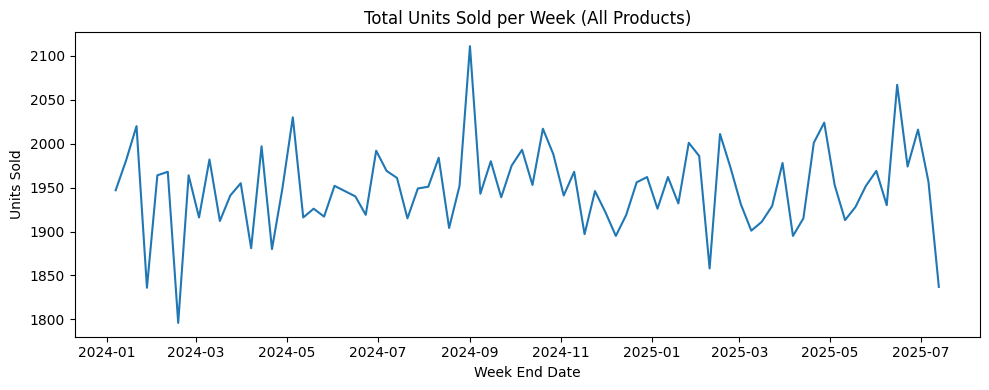

In [5]:
# ============================
# 1.5 Visualize aggregate demand
# ============================
import matplotlib.pyplot as plt

agg = (df.groupby('week_end_date', as_index=False)['units_sold']
         .sum()
         .sort_values('week_end_date'))

plt.figure(figsize=(10,4))
plt.plot(agg['week_end_date'], agg['units_sold'])
plt.title("Total Units Sold per Week (All Products)")
plt.xlabel("Week End Date")
plt.ylabel("Units Sold")
plt.tight_layout()
plt.show()


Top revenue product: P013


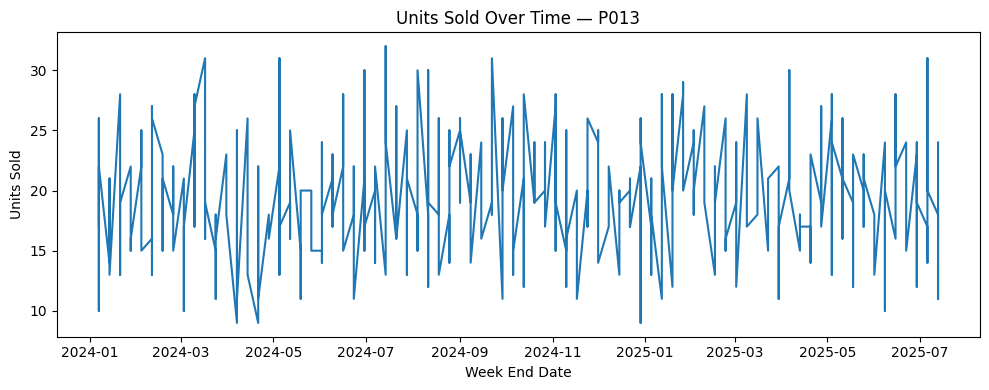

In [6]:
# ============================
# 1.6 Visualize top product demand
# ============================
top_prod = (df.groupby('product_id', as_index=False)['revenue_inr']
              .sum()
              .sort_values('revenue_inr', ascending=False)
              .iloc[0, 0])
print("Top revenue product:", top_prod)

one = df[df['product_id']==top_prod].copy().sort_values('week_end_date')

plt.figure(figsize=(10,4))
plt.plot(one['week_end_date'], one['units_sold'])
plt.title(f"Units Sold Over Time — {top_prod}")
plt.xlabel("Week End Date")
plt.ylabel("Units Sold")
plt.tight_layout()
plt.show()


In [7]:
# ============================
# 1.7 Feature correlation snapshot
# ============================
num_df = one[["units_sold", "units_returned", "unit_price_inr", "revenue_inr",
              "promo_flag", "discount_rate", "avg_temp_c", "rainfall_mm",
              "neighborhood_trend_index", "is_festival_season"]].copy()

corr = num_df.corr(numeric_only=True)
display(corr.style.background_gradient(cmap="coolwarm"))


,units_sold,units_returned,unit_price_inr,revenue_inr,promo_flag,discount_rate,avg_temp_c,rainfall_mm,neighborhood_trend_index,is_festival_season
units_sold,1.000000,0.391261,0.089746,0.573407,0.016118,-0.105680,-0.024806,-0.022625,-0.078482,-0.037631
units_returned,0.391261,1.000000,0.040323,0.226751,0.135510,0.038318,0.030760,-0.029610,0.014486,-0.048614
unit_price_inr,0.089746,0.040323,1.000000,0.845358,0.020121,0.065578,-0.027430,0.086336,0.049696,-0.009277
revenue_inr,0.573407,0.226751,0.845358,1.000000,0.036424,-0.005819,-0.031595,0.052305,0.004805,-0.015509
promo_flag,0.016118,0.135510,0.020121,0.036424,1.000000,-0.032997,-0.043810,0.022877,0.092838,-0.080427
discount_rate,-0.105680,0.038318,0.065578,-0.005819,-0.032997,1.000000,-0.005797,0.094049,-0.016664,0.034946
avg_temp_c,-0.024806,0.030760,-0.027430,-0.031595,-0.043810,-0.005797,1.000000,-0.002883,0.042561,-0.093508
rainfall_mm,-0.022625,-0.029610,0.086336,0.052305,0.022877,0.094049,-0.002883,1.000000,0.000497,0.065006
neighborhood_trend_index,-0.078482,0.014486,0.049696,0.004805,0.092838,-0.016664,0.042561,0.000497,1.000000,0.008134
is_festival_season,-0.037631,-0.048614,-0.009277,-0.015509,-0.080427,0.034946,-0.093508,0.065006,0.008134,1.000000


In [8]:
# ============================
# 2.1 Aggregate by Product Week
# ============================
# Ensure aggregation at product-week level (sums for counts, means for continuous signals)
agg_funcs = {
    "units_sold": "sum",
    "units_returned": "sum",
    "revenue_inr": "sum",
    "unit_price_inr": "mean",
    "promo_flag": "sum",  # total stores running promo
    "discount_rate": "mean",
    "avg_temp_c": "mean",
    "rainfall_mm": "mean",
    "neighborhood_trend_index": "mean",
    "is_festival_season": "max"  # 1 if any store flagged it
}

df_weekly = (df.groupby(["product_id", "week_end_date"], as_index=False)
               .agg(agg_funcs)
               .sort_values(["product_id","week_end_date"])
               .reset_index(drop=True))
print("Shape:", df_weekly.shape)
display(df_weekly.head(10))

Shape: (1600, 12)


,product_id,week_end_date,units_sold,units_returned,revenue_inr,unit_price_inr,promo_flag,discount_rate,avg_temp_c,rainfall_mm,neighborhood_trend_index,is_festival_season
0,P001,2024-01-07,103,11,182963,1816.0,2,0.05,27.02,14.76,95.30,1
1,P001,2024-01-14,111,8,235674,2111.0,2,0.03,26.52,19.46,108.62,1
2,P001,2024-01-21,93,11,263529,2746.6,0,0.00,27.16,22.94,97.08,1
3,P001,2024-01-28,95,6,311624,3284.0,0,0.04,25.74,20.18,101.90,1
4,P001,2024-02-04,77,8,182410,2357.0,0,0.07,26.74,15.70,102.82,0
5,P001,2024-02-11,117,6,282309,2457.2,0,0.02,28.56,14.04,97.46,0
6,P001,2024-02-18,86,10,195262,2262.8,1,0.03,30.14,16.90,104.52,0
7,P001,2024-02-25,74,8,201807,2621.4,3,0.10,29.74,21.34,97.48,0
8,P001,2024-03-03,110,5,282263,2511.8,0,0.04,28.96,22.30,97.14,0
9,P001,2024-03-10,89,9,168776,1901.2,1,0.00,29.58,22.24,104.06,0


In [9]:
# ============================
# 2.2 ABC Analysis
# ============================
# Compute total revenue per product
revenue_per_prod = (df_weekly.groupby("product_id", as_index=False)["revenue_inr"]
                              .sum()
                              .sort_values("revenue_inr", ascending=False))
# Cumulative revenue share
total_rev = revenue_per_prod["revenue_inr"].sum()
revenue_per_prod["cum_share"] = revenue_per_prod["revenue_inr"].cumsum() / total_rev * 100

# Assign ABC class
def abc_class(x):
    if x <= 80: return "A"   # top 80%
    elif x <= 95: return "B" # next 15%
    else: return "C"         # last 5%
revenue_per_prod["ABC"] = revenue_per_prod["cum_share"].apply(abc_class)

display(revenue_per_prod)

,product_id,revenue_inr,cum_share,ABC
12,P013,19321524,5.168248,A
0,P001,19290742,10.328262,A
5,P006,19152806,15.451381,A
7,P008,19133832,20.569424,A
11,P012,19117194,25.683016,A
9,P010,19040258,30.776029,A
14,P015,19025852,35.865189,A
19,P020,18991440,40.945144,A
8,P009,18910284,46.003391,A
15,P016,18757241,51.020701,A


/tmp/ipython-input-3456866629.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(revenue_per_prod["product_id"], rotation=45, ha="right")


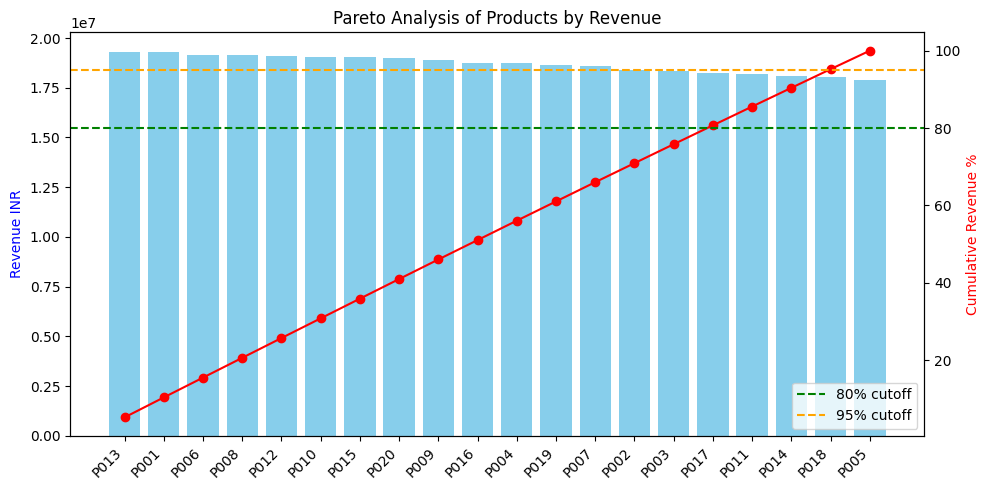

In [10]:
# ============================
# 2.3 Pareto Chart
# ============================
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
ax = plt.gca()

# Bar for revenue
ax.bar(revenue_per_prod["product_id"], revenue_per_prod["revenue_inr"], color="skyblue")
ax.set_ylabel("Revenue INR", color="blue")
ax.set_xticklabels(revenue_per_prod["product_id"], rotation=45, ha="right")

# Line for cumulative share
ax2 = ax.twinx()
ax2.plot(revenue_per_prod["product_id"], revenue_per_prod["cum_share"], color="red", marker="o")
ax2.axhline(80, color="green", linestyle="--", label="80% cutoff")
ax2.axhline(95, color="orange", linestyle="--", label="95% cutoff")
ax2.set_ylabel("Cumulative Revenue %", color="red")
ax2.legend(loc="lower right")

plt.title("Pareto Analysis of Products by Revenue")
plt.tight_layout()
plt.show()

In [13]:
# ============================
# 2.4 A Class SKUs Analysis
# ============================
A_prods = revenue_per_prod[revenue_per_prod["ABC"]=="A"]["product_id"].tolist()
print("A-class products:", A_prods)



A-class products: ['P013', 'P001', 'P006', 'P008', 'P012', 'P010', 'P015', 'P020', 'P009', 'P016', 'P004', 'P019', 'P007', 'P002', 'P003']


In [14]:
# ============================
# 3.1 Imports
# ============================
import numpy as np
import torch
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader


In [15]:
# ============================
# 3.2 Pick A Class Product
# ============================
# Pick one product for now
prod_id = "P013"
df_prod = df_weekly[df_weekly["product_id"] == prod_id].copy().reset_index(drop=True)

print("Shape:", df_prod.shape)
display(df_prod.head())


Shape: (80, 12)


,product_id,week_end_date,units_sold,units_returned,revenue_inr,unit_price_inr,promo_flag,discount_rate,avg_temp_c,rainfall_mm,neighborhood_trend_index,is_festival_season
0,P013,2024-01-07,94,11,258824,2653.2,0,0.02,25.04,18.36,97.40,1
1,P013,2024-01-14,79,9,159452,2090.8,0,0.00,26.80,13.08,97.48,1
2,P013,2024-01-21,106,9,271359,2742.0,0,0.00,27.94,13.90,101.08,1
3,P013,2024-01-28,94,11,216133,2250.4,1,0.02,27.86,14.68,103.82,1
4,P013,2024-02-04,100,12,257267,2579.0,1,0.06,27.80,30.86,103.38,0


In [16]:
# ============================
# 3.3. Feature Selection
# ============================
# Target = units_sold
target_col = "units_sold"

# Features: all drivers except product_id/week_end_date
feature_cols = [
    "units_returned", "unit_price_inr", "revenue_inr",
    "promo_flag", "discount_rate", "avg_temp_c", "rainfall_mm",
    "neighborhood_trend_index", "is_festival_season"
]

X = df_prod[feature_cols].values
y = df_prod[target_col].values.reshape(-1,1)

print("X shape:", X.shape, "y shape:", y.shape)


X shape: (80, 9) y shape: (80, 1)


In [17]:
# ============================
# 3.4 Scaling
# ============================
# Fit scalers
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

print("Scaled sample:", X_scaled[:3], y_scaled[:3])


Scaled sample: [[0.41176471 0.56478335 0.41982269 0.         0.15384615 0.49471831
  0.45513281 0.30473856 1.        ]
 [0.29411765 0.26614274 0.03528738 0.         0.         0.64964789
  0.26561378 0.30800654 1.        ]
 [0.29411765 0.61193713 0.46832881 0.         0.         0.75
  0.29504666 0.45506536 1.        ]] [[0.38636364]
 [0.04545455]
 [0.65909091]]


In [18]:
# ============================
# 3.5 Lookback -> Horizon Pairs
# ============================
def create_sequences(X, y, lookback=12, horizon=1):
    Xs, ys = [], []
    for i in range(len(X) - lookback - horizon + 1):
        Xs.append(X[i:(i+lookback)])
        ys.append(y[i+lookback : i+lookback+horizon])
    return np.array(Xs), np.array(ys)

lookback, horizon = 12, 1
X_seq, y_seq = create_sequences(X_scaled, y_scaled, lookback, horizon)

print("X_seq shape:", X_seq.shape)  # (samples, lookback, features)
print("y_seq shape:", y_seq.shape)  # (samples, horizon, 1)


X_seq shape: (68, 12, 9)
y_seq shape: (68, 1, 1)


In [19]:
# ============================
# 3.6 Train/Test/Val Split
# ============================
n_total = len(X_seq)
n_train = int(n_total * 0.7)
n_val   = int(n_total * 0.15)

X_train, y_train = X_seq[:n_train], y_seq[:n_train]
X_val, y_val     = X_seq[n_train:n_train+n_val], y_seq[n_train:n_train+n_val]
X_test, y_test   = X_seq[n_train+n_val:], y_seq[n_train+n_val:]

print("Train:", X_train.shape, y_train.shape)
print("Val:", X_val.shape, y_val.shape)
print("Test:", X_test.shape, y_test.shape)


Train: (47, 12, 9) (47, 1, 1)
Val: (10, 12, 9) (10, 1, 1)
Test: (11, 12, 9) (11, 1, 1)


In [20]:
# ============================
# 3.7 PyTorch Dataset
# ============================
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_ds = TimeSeriesDataset(X_train, y_train)
val_ds   = TimeSeriesDataset(X_val, y_val)
test_ds  = TimeSeriesDataset(X_test, y_test)

train_dl = DataLoader(train_ds, batch_size=16, shuffle=False)
val_dl   = DataLoader(val_ds, batch_size=16, shuffle=False)
test_dl  = DataLoader(test_ds, batch_size=16, shuffle=False)

print("Batches in train_dl:", len(train_dl))

Batches in train_dl: 3


In [22]:
# ============================
# 4.1 Univariate LSTM
# ============================
import torch.nn as nn

class UniLSTM(nn.Module):
  def __init__(self,hidden_size = 64, num_layers = 1,dropout = 0.0):
    super(UniLSTM,self).__init__()
    self.hidden_size = hidden_size
    self.num_layers = num_layers

    #LSTM Layer
    self.lstm = nn.LSTM(
        input_size = 1, #Only Units sold
        hidden_size = hidden_size,
        num_layers = num_layers,
        batch_first = True,
        dropout = dropout if num_layers>1 else 0.0
    )

    #Output Layer = Regression
    self.fc = nn.Linear(hidden_size,1)
  def forward(self,x):
    #X shape = (batch,lookback,1)
    out, _ = self.lstm(x) #out = (batch,lookback,hidden)
    last = out[:,-1,:] #Last hidden state
    y_pred = self.fc(last) #(batch,1)
    return y_pred

In [23]:
# ============================
# 4.2 Multivariate LSTM
# ============================
class MultiLSTM(nn.Module):
    def __init__(self, input_size=9, hidden_size=64, num_layers=2, dropout=0.2):
        super(MultiLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # LSTM layer
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0
        )

        # Output layer
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # x shape = (batch, lookback, features)
        out, _ = self.lstm(x)
        last = out[:, -1, :]
        y_pred = self.fc(last)
        return y_pred

In [24]:
# ============================
# 4.3 Initialize Models
# ============================
model_uni = UniLSTM(hidden_size=64, num_layers=1,dropout=0.0)
print(model_uni)
model_multi = MultiLSTM(input_size=9,hidden_size=64,num_layers=2,dropout=0.2)
print(model_multi)

UniLSTM(
  (lstm): LSTM(1, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)
MultiLSTM(
  (lstm): LSTM(9, 64, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)
